In [21]:
import cv2
import numpy as np
import tensorflow as tf
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
# TFLite interpreter
num_kps = 17
input_size = 256

interpreter = tf.lite.Interpreter(model_path="thunder_model.tflite")
interpreter.allocate_tensors()


switch = 0
dataAngles = [[[],[]],[[],[]]]
counter  =0
COLORS= {
    'm': (62, 74, 179),
    'c': (3, 4, 5),
    'y': (92, 13, 30),
}

EDGE_TO_COLOR = {
    (0, 1): COLORS['m'],
    (0, 2): COLORS['c'],
    (1, 3): COLORS['m'],
    (2, 4): COLORS['c'],
    (0, 5): COLORS['m'],
    (0, 6): COLORS['c'],
    (5, 7): COLORS['m'],
    (7, 9): COLORS['m'],
    (6, 8): COLORS['c'],
    (8, 10): COLORS['c'],
    (5, 6): COLORS['y'],
    (5, 11): COLORS['m'],
    (6, 12): COLORS['c'],
    (11, 12): COLORS['y'],
    (11, 13): COLORS['m'],
    (13, 15): COLORS['m'],
    (12, 14): COLORS['c'],
    (14, 16): COLORS['c'],
}

In [22]:
def calculate_angle(p1, p2, p3):
    radians = np.arctan2(p3[1] - p2[1], p3[0] - p2[0]) - np.arctan2(p1[1] - p2[1], p1[0] - p2[0])
    joint_angle = np.abs(radians * 180.0 / np.pi)

    if joint_angle > 180.0:
        joint_angle = 360 - joint_angle

    return joint_angle


# Computes if the given joints are horizontal according to the y axis position, within a given error.
def horizontal_joints(joints_y, y_axis, error):
    for y in joints_y:
        if not(y_axis - error <= y <= y_axis + error):
            return False
    return True


# Computes if the given joints are vertical according to the x axis position, within a given error.
def vertical_joints(joints_x, x_axis, error):
    for x in joints_x:
        if not(x_axis - error <= x <= x_axis + error):
            return False
    return True


def joint_in_region(x, y, x_axis, y_axis, x_error, y_error):
    return x_axis - x_error <= x <= x_axis + x_error and y_axis - y_error <= y <= y_axis + y_error


def angle_in_region(angle, expected_radius, radius_error):
    return expected_radius - radius_error <= angle <= expected_radius + radius_error


In [23]:
temp = 0
# Draws the angle on the reference joint.
def visualize_angle(frame, pos, angle):
    cv2.putText(
        img=frame,
        text=str(angle),
        org=pos,
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.0,
        color=(0, 255, 0),
        thickness=2,
        lineType=cv2.LINE_AA
    )

# # Computes the pose similarity of 2 different poses, using the Mean Absolute Error Method.
# def compute_pose_similarity(self, joints1, joints2):
#     if len(joints2) == len(self._exercise_joints):
#         mae = 0
#     #     for j in self._exercise_joints:# NEED TO CHANGE THIS
#     #         mae += abs(np.linalg.norm(np.array(joints1[j]) - np.array(joints2[j])))
#     #     return mae
#     # else:
#     #     return 10000

def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])


In [24]:

def movenet(input_image):
    """Runs detection on an input image.
    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.
    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    interpreter.invoke() # Invoke inference.

    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])


    # print(keypoints_with_scores[0][0][5])

    temp = (calculate_angle(keypoints_with_scores[0][0][5], keypoints_with_scores[0][0][7], keypoints_with_scores[0][0][11])+calculate_angle(keypoints_with_scores[0][0][6], keypoints_with_scores[0][0][8], keypoints_with_scores[0][0][12]))
    
    # dataAngles[1][switch].append(calculate_angle(keypoints_with_scores[0][0][5], keypoints_with_scores[0][0][7], keypoints_with_scores[0][0][11])+calculate_angle(keypoints_with_scores[0][0][6], keypoints_with_scores[0][0][8], keypoints_with_scores[0][0][12]))
    
    #dataAngles[0][switch].append(keypoints_with_scores[0][0][9][1])
    

    #else:
    #    print(keypoints_with_scores[0][0][9][2]+"*******************")
    #print(keypoints_with_scores[0][0][5])
    #print(keypoints_with_scores[0][0][7])
    #print(keypoints_with_scores[0][0][9])

    #print(calculate_angle(keypoints_with_scores[0][0][5], keypoints_with_scores[0][0][7], keypoints_with_scores[0][0][9]))
    #print(dataAngles)

    return keypoints_with_scores

In [25]:
def pad(image, width, height):
    image_width = image.shape[1]
    image_height = image.shape[0]

    # get resize ratio
    resize_ratio = min(width / image_width, height / image_height)

    # compute new height and width
    new_width = int(resize_ratio * image_width)
    new_height = int(resize_ratio * image_height)
    new_img = cv2.resize(image, (new_width, new_height))

    # compute padded height and width
    pad_width = (width - new_width) // 2
    pad_height = (height - new_height) // 2

    padded_image = cv2.copyMakeBorder(new_img,
                                      pad_height,
                                      pad_height,
                                      pad_width,
                                      pad_width,
                                      cv2.BORDER_REPLICATE,
                                      value=0)

    return cv2.resize(padded_image, (input_size, input_size))



def get_inference(image):
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = pad(image, input_size, input_size)
    image = cv2.resize(image, (input_size, input_size))
    input_image = image

    input_image = np.expand_dims(input_image, axis=0)

    # Run model inference.
    kps = movenet(input_image)[0]
    

    return kps[0], image



def preprocess_kps(kps, height, width):
    for i in range(len(kps)):
        temp = kps[i][1]
        kps[i][1] = kps[i][0] * height
        kps[i][0] = temp * width
    return kps

def draw_pose(image, keypoints, radius=2):
    height, width, channel = image.shape
    kps = preprocess_kps(keypoints, height, width)
    for c in kps:
        x, y, s = c
        if s > 0.2:
            cv2.circle(image,
                       (int(x), int(y)),
                       radius, (41, 128, 185), -1)
    for edge_pair, color in EDGE_TO_COLOR.items():
        start, end = edge_pair
        x1, y1, s1 = kps[start]
        x2, y2, s2 = kps[end]
        cv2.line(image,
                 (int(x1), int(y1)),
                 (int(x2), int(y2)),
                 color, 1,
                 lineType=cv2.LINE_AA)
    return image

In [26]:
angleAll = []
vidAngle = []

In [27]:
def main(vidPath):
    cap = cv2.VideoCapture(vidPath)
    fname = 'op_' + str(vidPath.split("/")[-1])

    fps = cap.get(cv2.CAP_PROP_FPS)  # 25

    ## Writing the video with keypoints
    size = (input_size * 2, input_size * 2)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    video_writer = cv2.VideoWriter(fname, fourcc, fps, size)

    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        curr_kp, image = get_inference(frame)
        print(temp)
        vidAngle.append(temp)

        output = draw_pose(image, curr_kp)
        output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        outimage = np.asarray(output, dtype=np.uint8)
        outimage = cv2.resize(outimage, size)

        video_writer.write(outimage)
        cv2.imshow("frame", outimage)

        k = cv2.waitKey(1)
        if k == ord('q') or k == 27:
            break
    angleAll.append(vidAngle)
    cap.release()
    cv2.destroyAllWindows()

In [28]:
# vidpath='/Users/nick/Documents/Class_Notes/Capstone/dataa/incorrect/Untitled.mp4'

# # iterate over files in
# # that directory
# # for filename in os.listdir(directory):
# #     f = os.path.join(directory, filename)
# #     # checking if it is a file
# #     print(f)
# #     vidpath = f

# main(vidpath)
# # dataAngles[0][switch].append(list(range(0, len(dataAngles[1][switch]))))
# # switch = 1

# # # main(vidpath1)

# # # ratio = len(dataAngles[1][0])/len(dataAngles[1][1])

# # dataAngles[0][switch].append(list(range(0, len(dataAngles[1][switch]))))
# # # print(dataAngles[1][1])


# # # for i in range (0,len(dataAngles[1][1])):
# # #     dataAngles[0][1][0][i] = dataAngles[0][1][0][i]*ratio
# # #     # print(dataAngles[0][1][0])

# # # print(dataAngles[1][1])

# # from scipy.signal import medfilt

# # normalize = (np.array(dataAngles[1][0]).mean() + np.array(dataAngles[1][1]).mean()) /2
# # normal1 =  np.array(dataAngles[1][0]) -  normalize
# # normal2 = np.array(dataAngles[1][1]) - normalize
# # print(DTWDistance(dataAngles[1][0],dataAngles[1][1]))


# # plt.scatter(dataAngles[0][0],dataAngles[1][0])
# # plt.scatter(dataAngles[0][1],dataAngles[1][1])
# # plt.show()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [29]:
import difflib

In [30]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [291]:
x_train_data = pd.read_csv('/Users/nick/Documents/Class_Notes/Capstone/se4450-project-group-24/AI model/courses.csv')
videos = []
temp = []

print(x_train_data)

for x in range(1,len(x_train_data)):
    temp.append(x_train_data['Angles'][x])
    
    if(x_train_data['Frames'][x] == 0):
        videos.append(np.array(temp) )
        temp = []

print(len(videos))


# for idx,x in enumerate(videos):

#     # if (idx == 30):
#     #     break
#     # plt.scatter(np.linspace(1,len(x),len(x)),x)


plt.show()





      Unnamed: 0     Frames      Angles
0              0   0.000000  318.190134
1              1   1.000000  307.778631
2              2   2.000000  300.946297
3              3   3.000000  283.372521
4              4   4.000000  268.087842
...          ...        ...         ...
7639        7639  37.590361  340.830422
7640        7640  38.072289  344.336700
7641        7641  38.554217  342.259421
7642        7642  39.036145  342.089813
7643        7643  39.518072  341.787728

[7644 rows x 3 columns]
126


      Unnamed: 0      NoUse           1          0
0              0   0.000000  292.374615   0.000000
1              1   1.000000  276.325979   1.333333
2              2   2.000000  265.235910   2.666667
3              3   3.000000  254.902353   4.000000
4              4   4.000000  238.936690   5.333333
...          ...        ...         ...        ...
2286        2286  27.630435  274.865985  36.840580
2287        2287  28.304348  284.159700  37.739130
2288        2288  28.978261  296.635369  38.637681
2289        2289  29.652174  305.024590  39.536232
2290        2290  30.326087  302.242189  40.434783

[2291 rows x 4 columns]


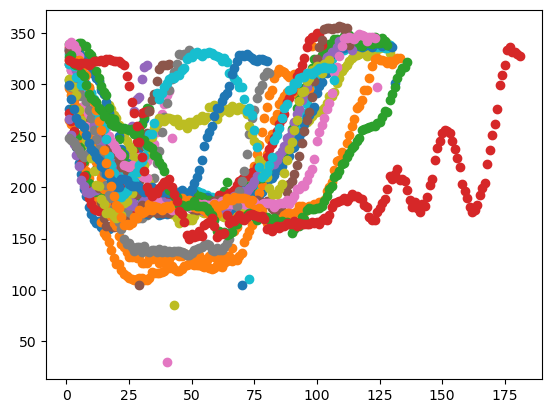

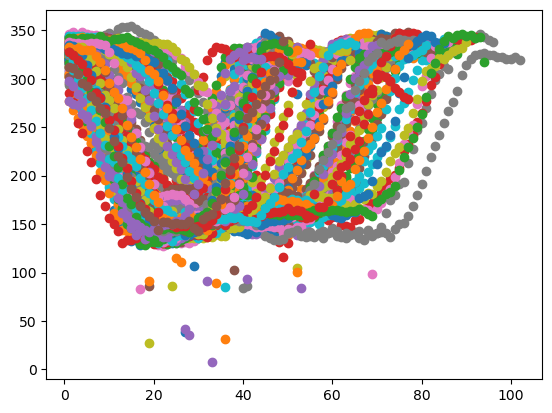

In [292]:
x_train_data = pd.read_csv('/Users/nick/Documents/AImodel/wrongForm.csv')
wrong = []
temp = []

print(x_train_data)

for x in range(1,len(x_train_data)):
    temp.append(x_train_data['1'][x])
    
    if(x_train_data['0'][x] == 0):
        wrong.append(np.array(temp) )
        temp = []




for idx,x in enumerate(wrong):

    # if (idx == 30):
    #     break
    plt.scatter(np.linspace(1,len(x),len(x)),x)


plt.show()

for idx,x in enumerate(videos):

    # if (idx == 30):
    #     break
    plt.scatter(np.linspace(1,len(x),len(x)),x)




In [214]:
max = -600

groundTruthIndex = 0

for x in range(0,len(videos)):
    avgTW = []
    avgT = []

    for w in wrong:
        avgTW.append(DTWDistance(videos[x],w))

    for w in videos:

        if w !=videos [x]:
            avgT.append(DTWDistance(videos[x],w))

    m = abs(np.array(avgTW).mean() - np.array(avgT).mean())
    if max < m:
        groundTruthIndex = x
        max = m



print(np.sort(avgTW))

[ 49.61810924  52.30594211  56.35725204  83.9686918   87.96887698
 110.75819867 115.21274171 119.72654974 130.26643587 138.3116443
 142.13430424 146.65843696 151.9672879  154.75187495 156.71157327
 163.92087264 178.25206138 183.04159198 187.18115689 190.57150958
 198.88956025 216.09200115 286.60943273 311.61533754]


In [161]:
print(groundTruthIndex)

37


In [215]:
avgTW = []
avgT = []

for w in wrong:
    avgTW.append(DTWDistance(videos[groundTruthIndex],w))

for w in videos:

    if w !=videos [groundTruthIndex]:
        avgT.append(DTWDistance(videos[groundTruthIndex],w))

In [167]:
np.array(avgTW).min()

126.76327967490346

In [ ]:
threshold = 126

In [293]:
X = []
labels = []
X.extend(videos)
labels.extend(np.zeros(len(videos)))

X.extend(wrong)
labels.extend(np.ones(24))

In [294]:
X

[array([307.7786312, 300.9462974, 283.3725212, 268.0878419, 257.6562989,
        242.2369282, 227.8646256, 214.0058713, 196.7927837, 183.3718991,
        164.047081 , 156.7339155, 146.8557134, 145.0353314, 132.2420319,
        133.0514093, 128.6665371, 134.645876 , 137.3433089, 132.1909694,
        136.5926985, 137.3367793, 140.8922479, 149.553037 , 157.9935663,
        167.8591188, 182.2393991, 194.7686981, 211.47127  , 226.8114924,
        235.7436586, 257.7602543, 272.0176595, 284.9843365, 302.918856 ,
        317.7323205, 324.7356687, 330.8954338, 329.4120396, 325.4454892]),
 array([325.5707686, 324.9374051, 323.0288044, 320.1101279, 315.4572801,
        309.5960353, 306.7359892, 300.2223246, 289.597296 , 274.9589985,
        275.1970443, 267.5287226, 260.2066368, 258.0180257, 249.3629739,
        237.6043388, 228.1283256, 221.7762496, 212.8194947, 206.2225975,
        205.5607248, 198.5705453, 190.6327727, 181.6838588, 175.7663742,
        171.7595666, 168.3122336, 171.1783175, 16

In [263]:
import seaborn as sns
df = pd.DataFrame(data={'angle': np.array(X),'frame':(np.linspace(0,len(X),len(X))),'labels':np.array(labels)})

AttributeError: module 'pandas' has no attribute 'DatXaFrame'

In [300]:
len(np.array(X))

for i,data in enumerate(X):
    X[i] = np.array(X[i],dtype=float)

/var/folders/5z/9k8_gbb14dx0k7c9_rrcj5mc0000gn/T/ipykernel_50688/3253688161.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  len(np.array(X))


In [301]:
n = np.array(X,dtype=object)

ValueError: setting an array element with a sequence.

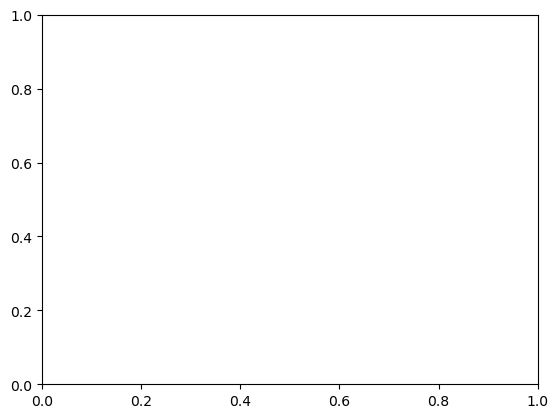

In [306]:
plt.scatter(X,np.linspace(0,len(X),len(X)))